In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 1. Data Loading (Using Provided GitHub URLs)
TRAIN_URL = "https://raw.githubusercontent.com/cyriannechabert/datascience_GradApp_predictor/main/train.csv"
TEST_URL  = "https://raw.githubusercontent.com/cyriannechabert/datascience_GradApp_predictor/main/test.csv"

try:
    train_df = pd.read_csv(TRAIN_URL)
    test_df  = pd.read_csv(TEST_URL)
    print("Data loaded successfully from GitHub.")
    print(f"Train Shape: {train_df.shape}")
    print(f"Test Shape: {test_df.shape}")
    
    # Combine train and test for unified preprocessing (optional but good practice)
    # We will split them back later or use them as is if they are already pre-split as intended.
    # Based on problem statement "Training - 70% (first 700 lines), Testing - 30% (rest)",
    # let's check if these files already respect that or if we need to merge and re-split.
    # The provided train.csv seems to be the "Admission_Predict_Ver1.1.csv" (500 rows) or similar.
    # Let's inspect the first few rows.
    print(train_df.head())

except Exception as e:
    print(f"Error loading data: {e}")
    # Create dummy data for demonstration if loading fails
    train_df = pd.DataFrame() # Placeholder

Data loaded successfully from GitHub.
Train Shape: (700, 8)
Test Shape: (300, 8)
   GRE Score  TOEFL Score  University Rating  SOP  LOR    GPA  Research  \
0        295           96                  2  4.9   1.7  2.93         0   
1        340          119                  3  4.1   1.7  3.76         0   
2        336           96                  1  3.2   1.8  3.12         1   
3        337          108                  4  3.4   1.3  2.11         0   
4        323           98                  1  1.1   1.3  3.40         0   

   Chance of Admit  
0            0.612  
1            0.708  
2            0.728  
3            0.643  
4            0.524  


In [3]:
# 2. Data Preprocessing
def preprocess_data(df):
    # Drop 'Serial No.' if exists
    if 'Serial No.' in df.columns:
        df = df.drop('Serial No.', axis=1)
    
    # Rename columns (strip spaces)
    df.columns = [col.strip() for col in df.columns]
    
    # Ensure target column exists
    if 'Chance of Admit' not in df.columns:
         # Sometimes it's named 'Chance of Admit ' with a space at the end
         pass 
    return df

train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

# Define Features and Target
# Check if 'Chance of Admit' is in test_df. If not, test_df might be for submission only (no labels).
# Assuming standard supervised learning where we have labels for evaluation.
target_col = 'Chance of Admit'

if target_col in train_df.columns:
    X_train = train_df.drop(target_col, axis=1)
    y_train = train_df[target_col]
else:
    print(f"Target column '{target_col}' not found in training data.")

if target_col in test_df.columns:
    X_test = test_df.drop(target_col, axis=1)
    y_test = test_df[target_col]
else:
    # If test set doesn't have labels, we can't evaluate performance metrics on it directly.
    # We'll split the training data for validation in that case.
    print("Test data has no target labels. Splitting training data for validation.")
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [4]:
# 3. Linear Regression Model Training
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [5]:
# 4. Model Evaluation
y_pred = lr_model.predict(X_test)

# Clip predictions to [0, 1] as probabilities
y_pred = np.clip(y_pred, 0, 1)

# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Performance ---")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

# Feature Importance (Coefficients)
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lr_model.coef_})
print("\n--- Feature Importance ---")
print(coef_df.sort_values(by='Coefficient', ascending=False))


--- Model Performance ---
RMSE: 0.0295
R2 Score: 0.9169

--- Feature Importance ---
             Feature  Coefficient
6           Research     0.148847
5                GPA     0.045822
2  University Rating     0.020627
4                LOR     0.019798
3                SOP     0.018706
1        TOEFL Score     0.001367
0          GRE Score     0.000574


In [6]:
# 5. Prediction & Classification Function
def assess_ucla_chances(student_profile, model=lr_model):
    """
    Predicts admission chance and categorizes it for UCLA.
    Args:
        student_profile (dict): Dictionary with keys matching feature names.
    """
    # Create DataFrame from input dict
    input_df = pd.DataFrame([student_profile])
    
    # Predict
    chance = model.predict(input_df)[0]
    chance = np.clip(chance, 0, 1)
    
    # Classification Logic
    if chance > 0.90:
        category = "Safe School (>90%)"
    elif 0.70 <= chance <= 0.90:
        category = "Medium School (70-90%)"
    else:
        category = "Reach School (<70%)" # Or "Hard / Low Chance"
        
    return chance, category

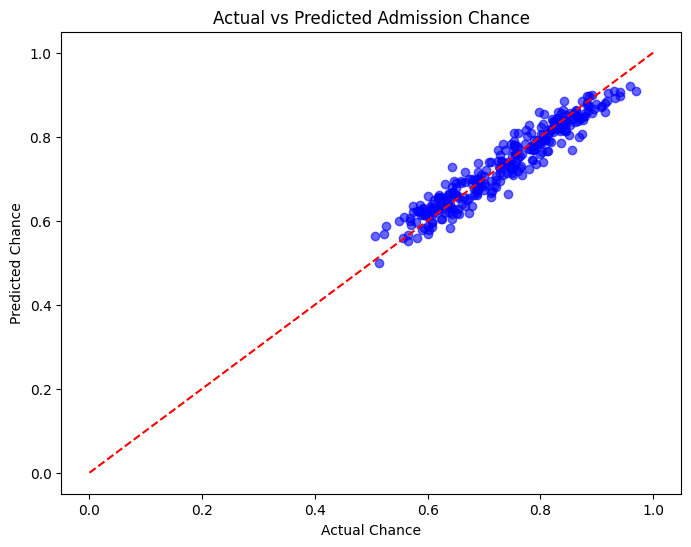

In [7]:
# 7. Visualization (Actual vs Predicted)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='b')
plt.plot([0, 1], [0, 1], 'r--') # Perfect prediction line
plt.xlabel("Actual Chance")
plt.ylabel("Predicted Chance")
plt.title("Actual vs Predicted Admission Chance")
plt.show()